In [28]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from tqdm import tqdm

In [3]:
dataset_1 = pd.read_csv("dataset_1.csv")
dataset_2 = pd.read_csv("dataset_2.csv")
dataset_3 = pd.read_csv("dataset_3.csv")
dataset_4 = pd.read_csv("dataset_4.csv")
dataset_5 = pd.read_csv("dataset_5.csv")
dataset_6 = pd.read_csv("dataset_6.csv")
datasets = [dataset_1, dataset_2, dataset_3, dataset_4, dataset_5, dataset_6]

## 10-Fold Cross Validation

In [5]:
def train_valid_mse_cv(
    dataset: pd.DataFrame,
    degree: int,
    k_folds: int = 10,
    alpha: float = 0.0,
    regularization: str = "none",
) -> dict[str, float | Ridge | Lasso]:
    """Train a polynomial regression with a selected degree model using k-fold.

    For each alpha and fold calculates the MSE on the training and validation sets.

    Parameters
    ----------
    dataset : pd.DataFrame
        Pandas DataFrame with the dataset. It must have two columns: "X" and "y".
    degree : int
        Degree of the polynomial features.
    k_folds : int, optional
        Number of folds for the k-fold cross-validation, by default 10.
    alpha : float, optional
        Alpha value for the regularization, by default 0.0.
    regularization : str, optional
        Type of regularization to use ("none", "l1", "l2"), by default "none".

    Returns
    -------
    dict[str, float | Ridge | Lasso]
        Dictionary with the mean MSE for the training and validation
        sets from all the folds. The dictionary also contains the best model for
        the dataset.
    """
    if regularization not in ["none", "l1", "l2"]:
        raise ValueError("Regularization must be 'none', 'l1' or 'l2'.")

    mse_dict = {"mse_train": None, "mse_valid": None, "model": None}

    # Split the dataset into k folds
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    models_list = []
    mse_train_list = []
    mse_valid_list = []
    for train_index, val_index in kf.split(dataset):
        train_set = dataset.iloc[train_index]
        val_set = dataset.iloc[val_index]

        X_train = train_set[["X"]]
        y_train = train_set["y"]

        X_val = val_set[["X"]]
        y_val = val_set["y"]

        # Transform features into polynomial
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        # Select the model based on the regularization type
        # Apply StandardScaler to the model to normalize the features
        # and avoid numerical instability
        # High `max_iter` to avoid convergence warnings
        if regularization == "l1":
            model = make_pipeline(
                StandardScaler(), Lasso(alpha=alpha, max_iter=1000000)
            )
        elif regularization == "l2":
            model = make_pipeline(
                StandardScaler(), Ridge(alpha=alpha, max_iter=1000000)
            )
        else:
            model = make_pipeline(
                StandardScaler(), Ridge(alpha=0.0, max_iter=1000000)
            )  # Equivalent to no regularization

        # Train the model
        model.fit(X_train_poly, y_train)
        models_list.append(model)

        # Predict on the train set
        y_train_pred = model.predict(X_train_poly)

        # Predict on the validation set
        y_val_pred = model.predict(X_val_poly)

        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_valid = mean_squared_error(y_val, y_val_pred)
        mse_train_list.append(mse_train)
        mse_valid_list.append(mse_valid)

    # Calculate the mean from all the folds
    mse_dict["mse_train"] = np.mean(mse_train_list)
    mse_dict["mse_valid"] = np.mean(mse_valid_list)

    # Get the model with lowest validation error
    best_model_idx = np.argmin(mse_valid_list)
    best_model = models_list[best_model_idx]
    mse_dict["model"] = best_model

    return mse_dict

In [6]:
def train_valid_mse(
    degrees: list[int],
    datasets: list[pd.DataFrame],
    k_folds: int = 10,
    alphas: list[float] = None,
    regularization: str = "none",
) -> dict[str, dict[str, list[float]]]:
    """Train polynomial regression for each dataset and degree. Uses k-fold CV.

    Parameters
    ----------
    degrees : list[int]
        List with the degrees of the polynomial features.
    datasets : list[pd.DataFrame]
        List with the datasets.
    k_folds : int, optional
        Number of folds for the k-fold cross-validation, by default 10.
    alphas : list[float], optional
        List with the lambda (alpha in scikit-learn) regularization parameter values,
        by default None.
    regularization : str, optional
        Type of regularization to use

    Returns
    -------
    dict[str, dict[str, list[float]]]
        Dictionary with the mean squared error for the training and validation sets
        for each dataset, alpha and degree; and the model with the lowest validation
        error.
    """
    if alphas is None:
        alphas = [0.0]  # Default to no regularization if alphas is not provided

    mse_per_dataset_dict = {
        f"dataset_{i + 1}": {
            "mse_train": {alpha: [] for alpha in alphas},
            "mse_valid": {alpha: [] for alpha in alphas},
            "model": {alpha: [] for alpha in alphas},
        }
        for i in range(len(datasets))
    }
    for i, dataset in tqdm(enumerate(datasets), desc="Datasets", total=len(datasets)):
        for alpha in alphas:
            mean_mse_train_list = []
            mean_mse_valid_list = []
            for d in degrees:
                mse_dict = train_valid_mse_cv(
                    dataset, d, k_folds, alpha=alpha, regularization=regularization
                )
                mse_per_dataset_dict[f"dataset_{i + 1}"]["model"][alpha].append(
                    mse_dict["model"]
                )

                mean_mse_train_list.append(mse_dict["mse_train"])
                mean_mse_valid_list.append(mse_dict["mse_valid"])

                mse_per_dataset_dict[f"dataset_{i + 1}"]["mse_train"][alpha] = (
                    mean_mse_train_list
                )
                mse_per_dataset_dict[f"dataset_{i + 1}"]["mse_valid"][alpha] = (
                    mean_mse_valid_list
                )

    return mse_per_dataset_dict

In [7]:
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
degrees = range(1, 16)

mse_per_dataset_dict_l1 = train_valid_mse(
    degrees=degrees,
    datasets=datasets,
    alphas=alphas,
    regularization="l1",  # Lasso
)

mse_per_dataset_dict_l2 = train_valid_mse(
    degrees=degrees,
    datasets=datasets,
    alphas=alphas,
    regularization="l2",  # Ridge
)

Datasets: 100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


## Plotting

### Training and Validation Error Evolution by Complexity and Alpha parameter

Para poder elaborar gráficas que permitan la comparación entre datasets, grados de regresión polinómica, error de entrenamiento y validación y valores de alpha, se decide construir un tipo de gráfico. Este consiste en una gráfica donde aparecen todas las curvas de entrenamiento y validación a lo largo de los grados de la regresión polinómica para un dataset. Cada par de curvas (validación y entrenamiento) son de un color en función del valor de alpha con el que se entreno dicha regresión polinómica.

Estas gráficas se construyen para la regresión de tipo Ridge y para la regreisón de tipo Lasso

#### Lasso

Lasso podría no converger. Con alpha muy grande, Lasso intenta forzar la mayoría de los coeficientes a cero y, si la configuración no está bien ajustada (por ejemplo, pocas iteraciones o un solver inadecuado), puede no encontrar la solución exacta.

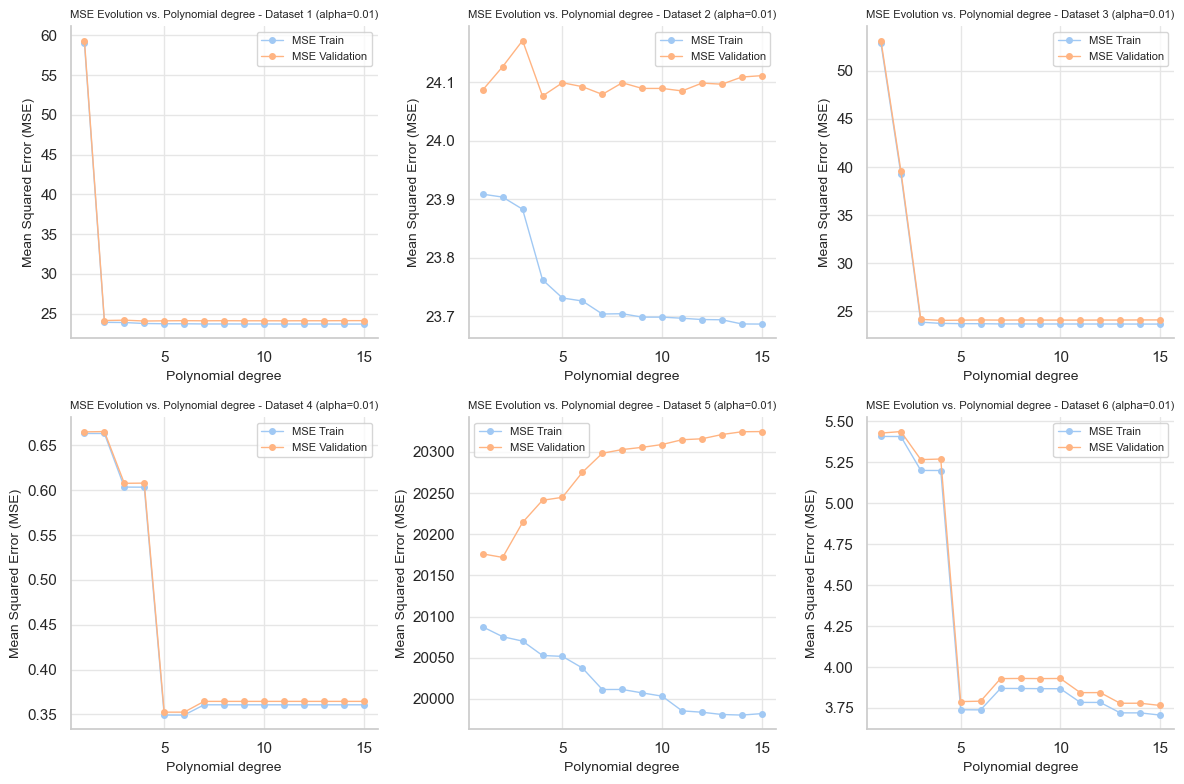

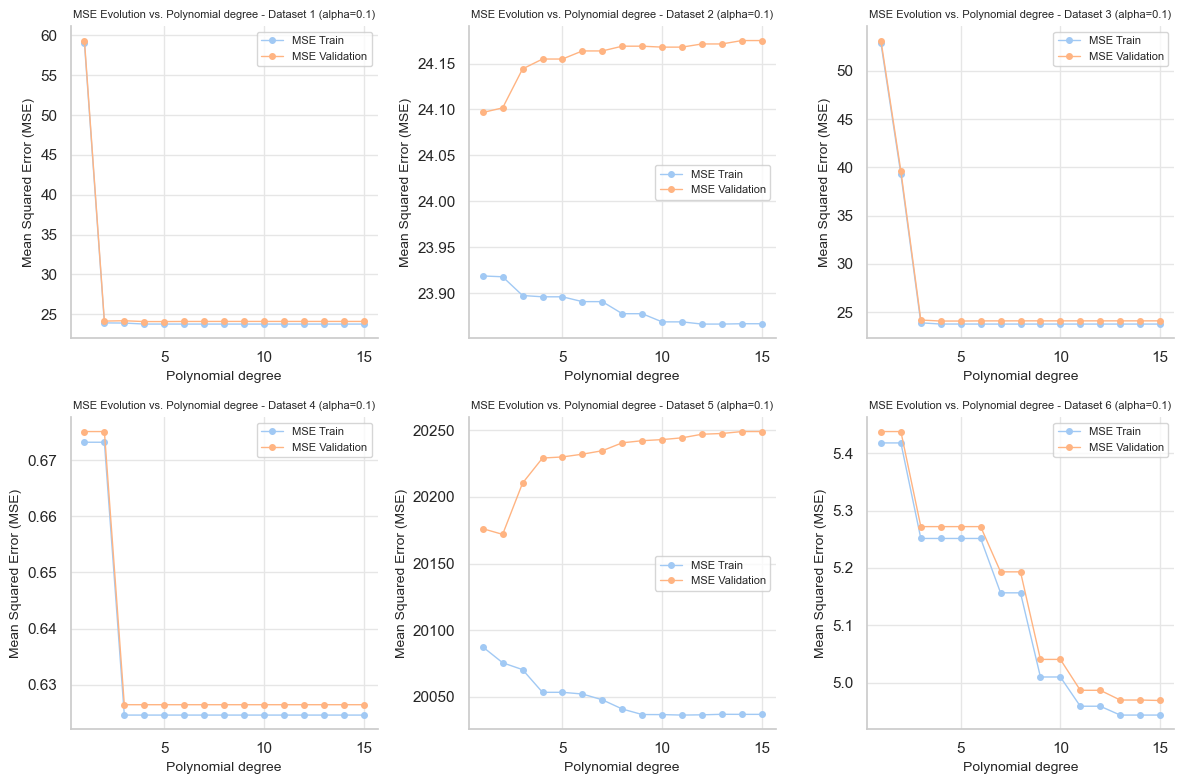

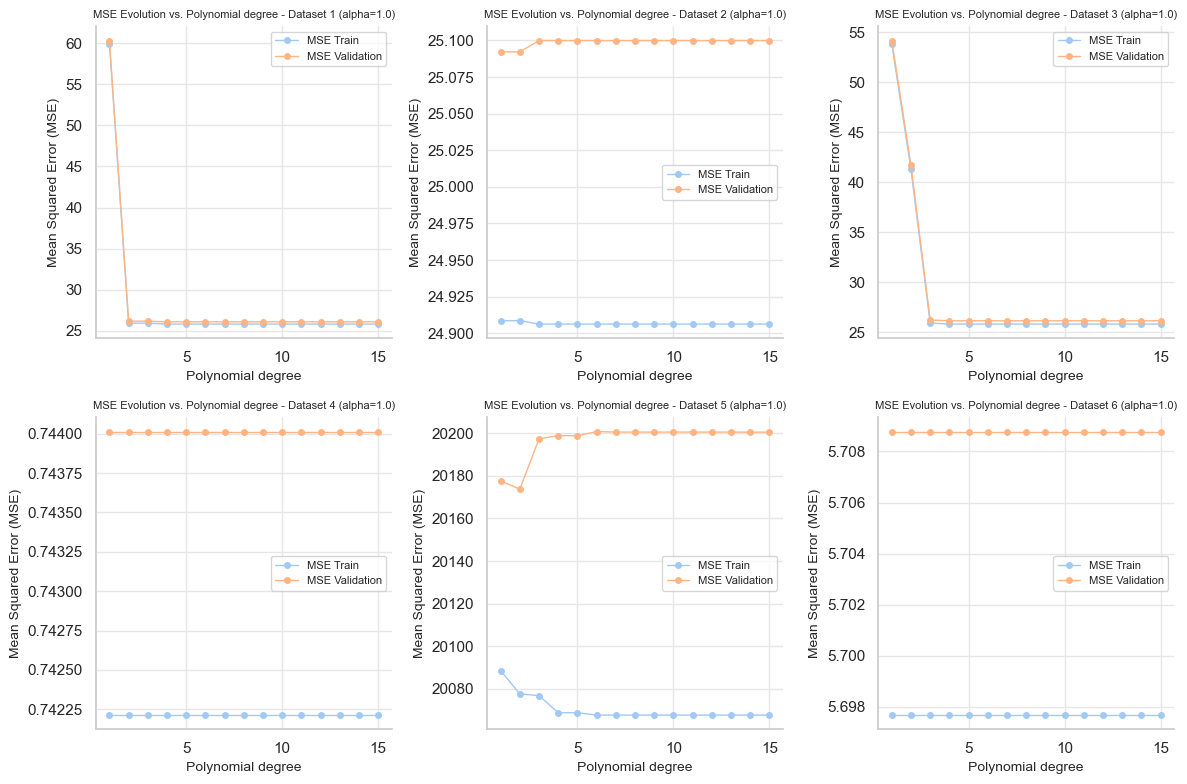

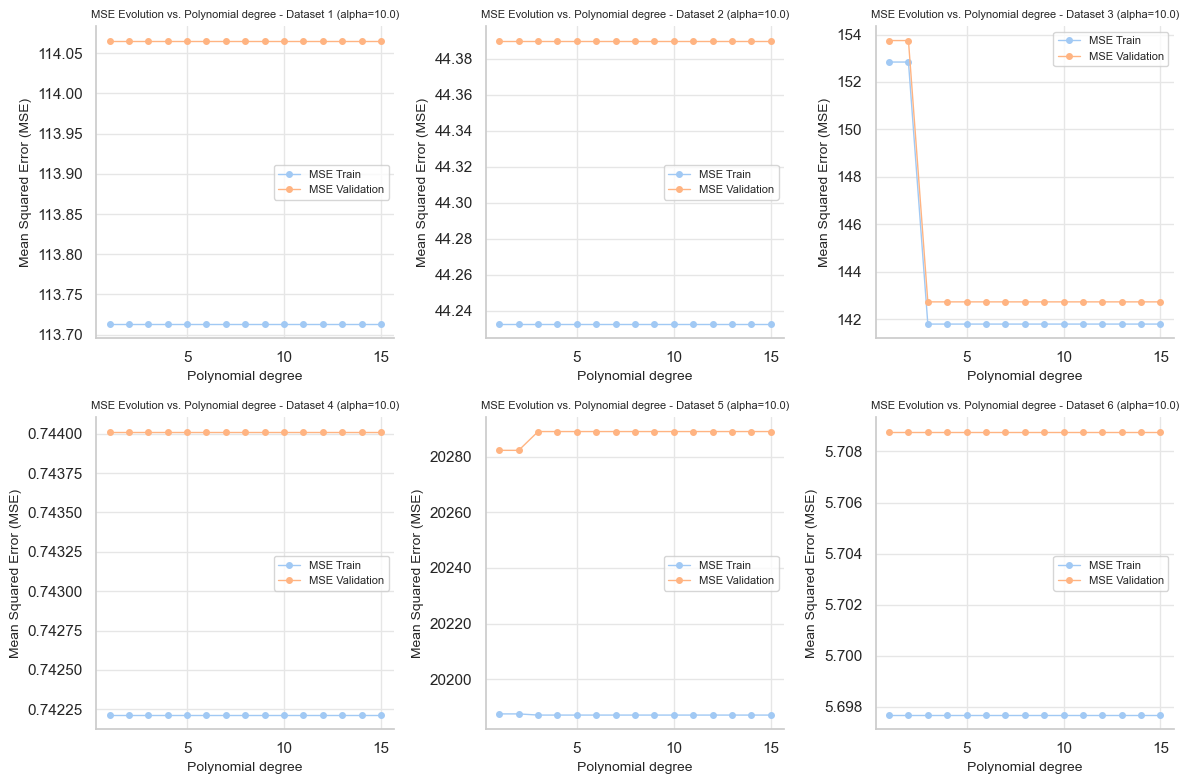

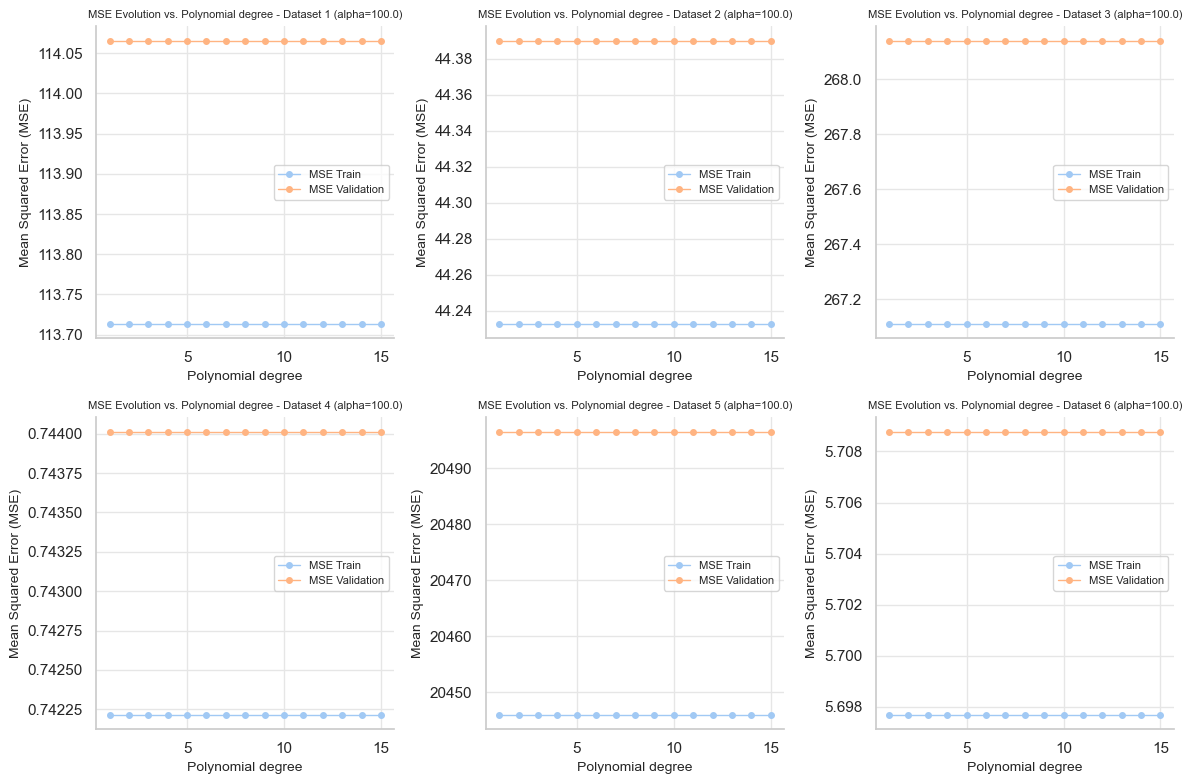

In [50]:
for alpha in alphas:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

    axes = axes.flatten()

    for i, (ax, dataset) in enumerate(zip(axes, mse_per_dataset_dict_l1)):
        ax.plot(
            degrees,  # Degrees
            mse_per_dataset_dict_l1[dataset]["mse_train"][alpha],
            marker="o",
            label="MSE Train",
            linewidth=1,  # Grosor de la curva
            markersize=4,  # Tamaño del marker
        )
        ax.plot(
            degrees,  # Degrees
            mse_per_dataset_dict_l1[dataset]["mse_valid"][alpha],
            marker="o",
            label="MSE Validation",
            linewidth=1,  # Grosor de la curva
            markersize=4,  # Tamaño del marker
        )
        validation_mse = mse_per_dataset_dict_l1[dataset]["mse_valid"][alpha]
        degree_min_mse = np.argmin(validation_mse) + 1

        # # Método de la segunda derivada para encontrar el punto de codo
        # second_derivative = np.diff(validation_mse, n=2)
        # elbow_point = (
        #     np.argmax(second_derivative) + 2
        # )  # +2 porque np.diff reduce el tamaño del array original en 2

        # ax.axvline(
        #     x=elbow_point, color="r", linestyle="--", label=f"Elbow x={elbow_point}"
        # )
        ax.set_xlabel("Polynomial degree", fontsize=10)  # Tamaño de la fuente
        ax.set_ylabel("Mean Squared Error (MSE)", fontsize=10)  # Tamaño de la fuente
        ax.set_title(
            f"MSE Evolution vs. Polynomial degree - Dataset {i + 1} (alpha={alpha})",
            fontsize=8,  # Tamaño de la fuente del título
        )
        ax.legend(fontsize=8)  # Tamaño de la fuente de la leyenda

    sns.despine()

    plt.tight_layout()
    plt.show()

Con estas gráficas, aunque resulta un poco complicado de visualizar, se puede observar que a medida que aumenta el valor del parámetro de regularización alpha (se fuerza a que los coeficientes sean más pequeños), la distancia entre el error de entrenamiento y el error de validación decrece, sin embargo, dado que la complejidad del modelo se está reduciendo debido a esta regularización, el error de entrenamiento y el de validación suben globalmente. Es decir, hay una reducción de la varianza aunque sufriendo un aumento del sesgo.

In [47]:
def plot_mse_per_alpha_curves(mse_per_dataset_dict: dict[str, dict[str, list[float]]], dataset_name: str):
    # Dataset selection
    dataset = mse_per_dataset_dict[dataset_name]

    # Viridis color list
    colors = px.colors.qualitative.Plotly

    fig = go.Figure()

    for alpha, color in zip(alphas, colors):
        # Training curve: solid line
        fig.add_trace(
            go.Scatter(
                x=degrees,
                y=dataset["mse_train"][alpha],
                mode="lines",
                line=dict(color=color, dash="solid"),
                name=f"alpha {alpha} train",
            )
        )

        # Validation curve: dashed line
        fig.add_trace(
            go.Scatter(
                x=degrees,
                y=dataset["mse_valid"][alpha],
                mode="lines",
                line=dict(color=color, dash="dash"),
                name=f"alpha {alpha} valid",
            )
        )

    fig.update_layout(
        title=f"MSE Curves (Train vs Valid) for different alpha values - {dataset_name}",
        xaxis_title="Degrees",
        yaxis_title="MSE",
        width=800,
        height=600,
    )

    fig.show()

In [48]:
for dataset in mse_per_dataset_dict_l1:
    plot_mse_per_alpha_curves(mse_per_dataset_dict_l1, dataset)

Con estas gráficas se puede observar de manera global lo que se mencionaba en el comentario anterior. Esto se puede observar claramente en el `dataset_5`. Por ejemplo, para un alpaha del `0.01`, se observa un bias relativamente sesgo respecto a las demas curvas pero una varianza en aumento a partir del grado 2. Sin embargo, en el momento en el que alpha tiene un valor superior a 10, este efecto se evita, viendo como las curvas de MSE de Train y de Validation son paralelas y la distancia entre ellas es menor y practicamente constante. Esto quiere decir que, aunque se ha reducido la capacidad del modelo en general (sufre un subajuste), se evita el sobreajuste reduciendo la varianza

En el caso de la regularización Lasso, el grado óptimo para cada dataset es:

| Dataset   | Alpha 0.01 | Alpha 0.1 | Alpha 1 | Alpha 10 | Alpha 100 |
|-----------|------------|-----------|---------|----------|-----------|
| Dataset_1 | Grado 2    | Grado 2   | Grado 2 | Grado 1. Ya que para un grado 1 el sesgo es mayor que para los modelos con menores alphas y a medida que aumente la complejidad del modelo este no varía. Esto se debe a que una gran cantidad de coeficientes serán 0. | Grado 1. Ya que para un grado 1 el sesgo es mayor que para los modelos con menores alphas y a medida que aumente la complejidad del modelo este no varía. Esto se debe a que una gran cantidad de coeficientes serán 0. |
| Dataset_2 | Grado 4    | Grado 2   | Grado 1 | Grado 1. Ya que para un grado 1 el sesgo es mayor que para los modelos con menores alphas y a medida que aumente la complejidad del modelo este no varía. Esto se debe a que una gran cantidad de coeficientes serán 0. | Grado 1. Ya que para un grado 1 el sesgo es mayor que para los modelos con menores alphas y a medida que aumente la complejidad del modelo este no varía. Esto se debe a que una gran cantidad de coeficientes serán 0. |
| Dataset_3 | Grado 3    | Grado 3   | Grado 3 | Grado 3. | Grado 1. Ya que para un grado 1 el sesgo es mayor que para los modelos con menores alphas y a medida que aumente la complejidad del modelo este no varía. Esto se debe a que una gran cantidad de coeficientes serán 0. |
| Dataset_4 | Grado 5    | Grado 3   | Grado 1. Ya que para un grado 1 el sesgo es mayor que para los modelos con menores alphas y a medida que aumente la complejidad del modelo este no varía. Esto se debe a que una gran cantidad de coeficientes serán 0. | Grado 1. Ya que para un grado 1 el sesgo es mayor que para los modelos con menores alphas y a medida que aumente la complejidad del modelo este no varía. Esto se debe a que una gran cantidad de coeficientes serán 0. | Grado 1. Ya que para un grado 1 el sesgo es mayor que para los modelos con menores alphas y a medida que aumente la complejidad del modelo este no varía. Esto se debe a que una gran cantidad de coeficientes serán 0. |
| Dataset_5 | Grado 2    | Grado 2   | Grado 2. Ya que para un grado 1 el sesgo es mayor que para los modelos con menores alphas y a medida que aumente la complejidad del modelo este no varía. Esto se debe a que una gran cantidad de coeficientes serán 0. | Grado 2    | Grado 1. Ya que para un grado 1 el sesgo es mayor que para los modelos con menores alphas y a medida que aumente la complejidad del modelo este no varía. Esto se debe a que una gran cantidad de coeficientes serán 0. |
| Dataset_6 | Grado 15. Con grado 15 es donde menor sesgo y varianza hay. | Grado 15. Con grado 15 es donde menor sesgo y varianza hay. | Grado 1. Ya que para un grado 1 el sesgo es mayor que para los modelos con menores alphas y a medida que aumente la complejidad del modelo este no varía. Esto se debe a que una gran cantidad de coeficientes serán 0. | Grado 1. Ya que para un grado 1 el sesgo es mayor que para los modelos con menores alphas y a medida que aumente la complejidad del modelo este no varía. Esto se debe a que una gran cantidad de coeficientes serán 0. | Grado 1. Ya que para un grado 1 el sesgo es mayor que para los modelos con menores alphas y a medida que aumente la complejidad del modelo este no varía. Esto se debe a que una gran cantidad de coeficientes serán 0. |

#### Ridge

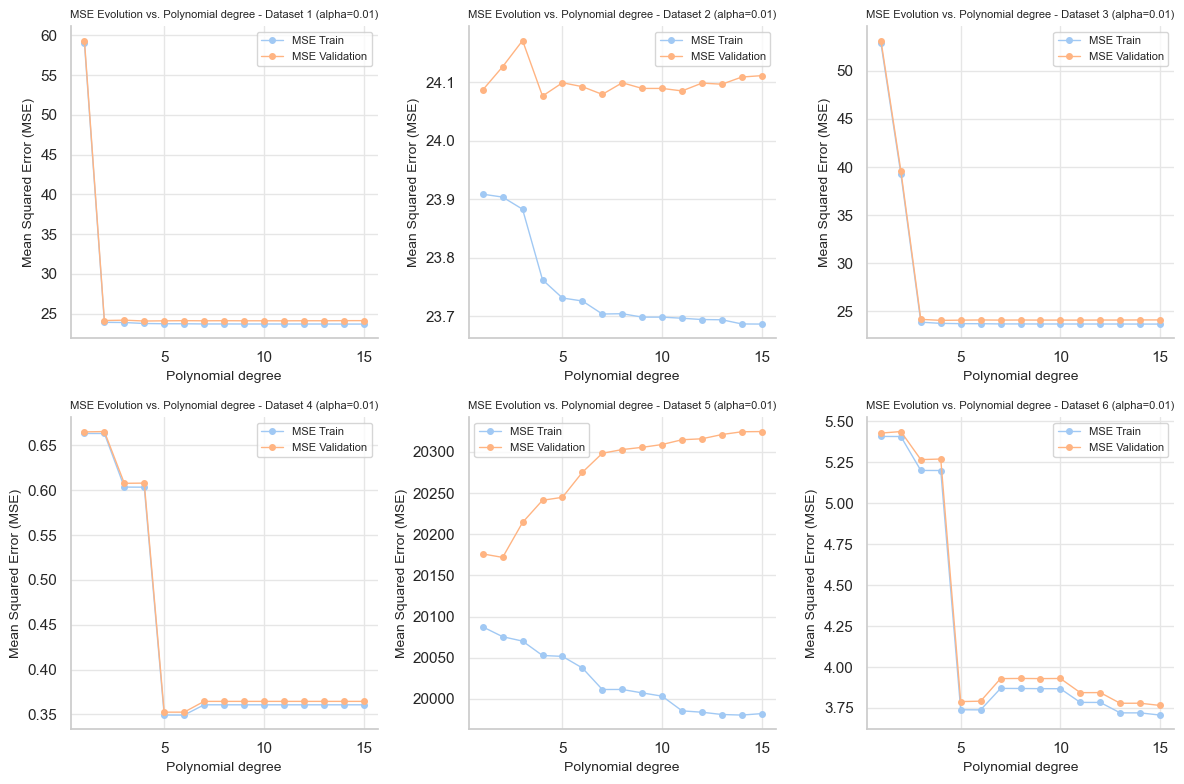

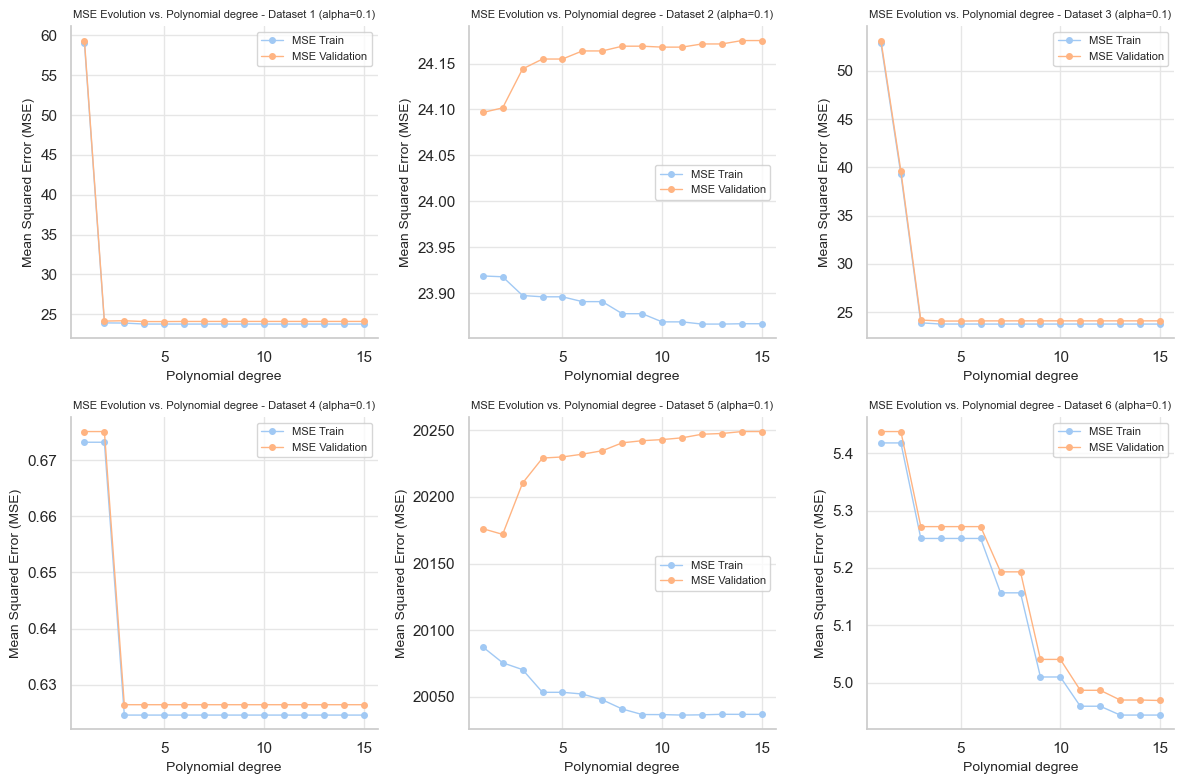

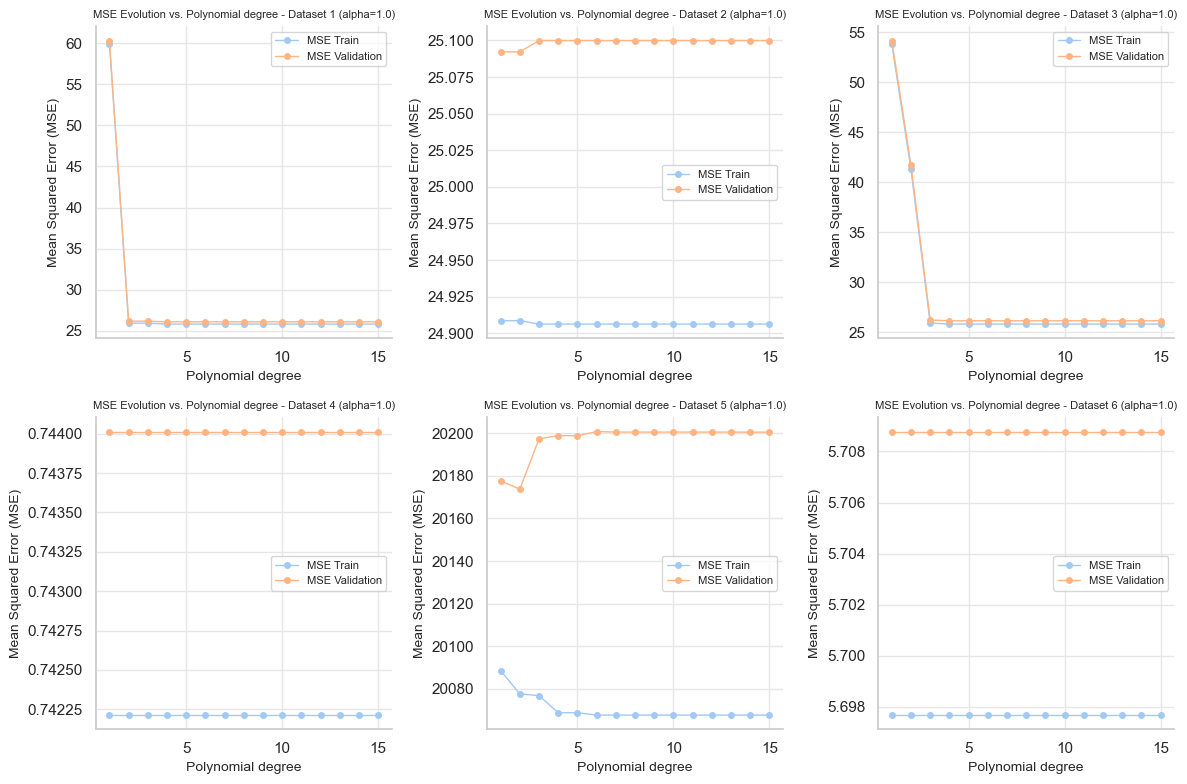

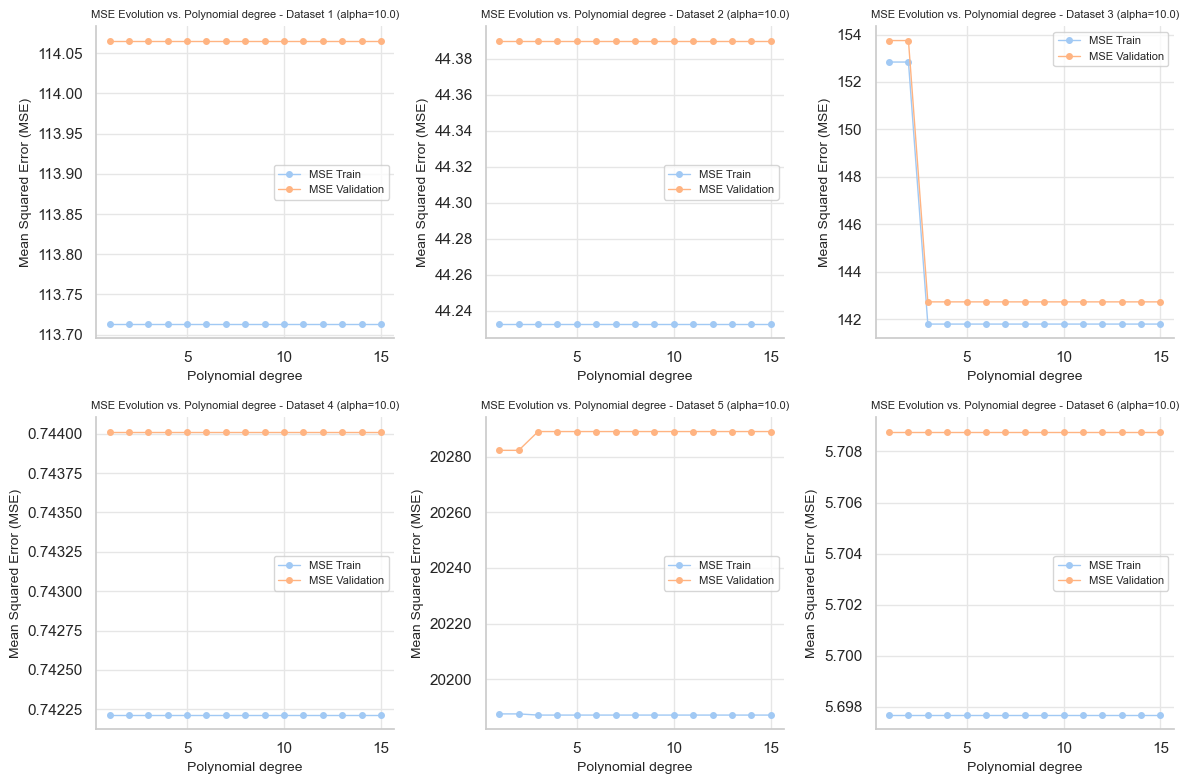

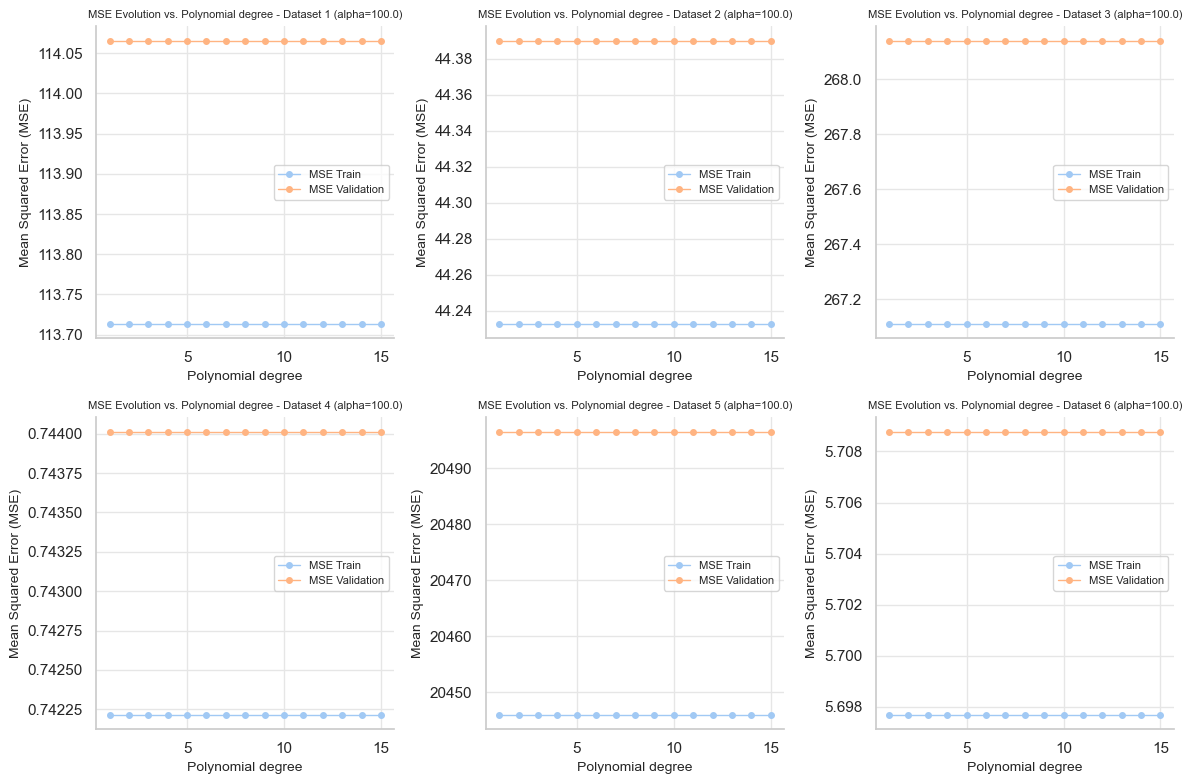

In [51]:
for alpha in alphas:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

    axes = axes.flatten()

    for i, (ax, dataset) in enumerate(zip(axes, mse_per_dataset_dict_l2)):
        ax.plot(
            degrees,  # Degrees
            mse_per_dataset_dict_l1[dataset]["mse_train"][alpha],
            marker="o",
            label="MSE Train",
            linewidth=1,  # Grosor de la curva
            markersize=4,  # Tamaño del marker
        )
        ax.plot(
            degrees,  # Degrees
            mse_per_dataset_dict_l1[dataset]["mse_valid"][alpha],
            marker="o",
            label="MSE Validation",
            linewidth=1,  # Grosor de la curva
            markersize=4,  # Tamaño del marker
        )
        validation_mse = mse_per_dataset_dict_l2[dataset]["mse_valid"][alpha]
        degree_min_mse = np.argmin(validation_mse) + 1

        # # Método de la segunda derivada para encontrar el punto de codo
        # second_derivative = np.diff(validation_mse, n=2)
        # elbow_point = (
        #     np.argmax(second_derivative) + 2
        # )  # +2 porque np.diff reduce el tamaño del array original en 2

        # ax.axvline(
        #     x=elbow_point, color="r", linestyle="--", label=f"Elbow x={elbow_point}"
        # )
        ax.set_xlabel("Polynomial degree", fontsize=10)  # Tamaño de la fuente
        ax.set_ylabel("Mean Squared Error (MSE)", fontsize=10)  # Tamaño de la fuente
        ax.set_title(
            f"MSE Evolution vs. Polynomial degree - Dataset {i + 1} (alpha={alpha})",
            fontsize=8,  # Tamaño de la fuente del título
        )
        ax.legend(fontsize=8)  # Tamaño de la fuente de la leyenda

    sns.despine()

    plt.tight_layout()
    plt.show()

De la misma manera que en el ejemplo anterior con Lasso, se observa que a medida que aumenta el valor del parámetro de regularización alpha, la distancia entre el error de entrenamiento y el error de validación decrece, mientras que el error de entrenamiento y el de validación suben globalmente

In [49]:
for dataset in mse_per_dataset_dict_l2:
    plot_mse_per_alpha_curves(mse_per_dataset_dict_l2, dataset)

En estas gráficas se observa de mejor manera cómo en los casos con alpha nulo o muy bajo realmente no se da un aumento de la varianza, como puede ser en el dataset_1, dataset_3, dataset_4 y dataset_6, por lo que la regularización afecta provocando un subajuste de los datos, aumentando el sesgo sin ofrecer beneficio en cuanto a una reducción significativa en la varianza. Esto se ve claramente en la gráfica del dataset_4, donde lo que se observa es que ambas curvas de MSE de entrenamiento y validación están cada vez por encima de los modelos con menor parámetro de regularización.

Sin embargo, en el caso contrario, como por ejemplo en el dataset_5, se observa claramente como el aumento de la regularización va reduciendo la pendiente de la curva del MSE de validación, mientras que la curva del MSE de entrenamiento va subiendo y tendiendo más a la horizontalidad

En el caso de la regularización Ridge, el grado óptimo para cada dataset es:

| Dataset   | Alpha 0.01 | Alpha 0.1 | Alpha 1 | Alpha 10 | Alpha 100 |
|-----------|------------|-----------|---------|----------|-----------|
| Dataset_1 | Grado 2    | Grado 2   | Grado 2 | Grado 2  | Grado 2   |
| Dataset_2 | Grado 4    | Grado 4   | Grado 5 | Grado 7  | Grado 11  |
| Dataset_3 | Grado 3    | Grado 3   | Grado 3 | Grado 3  | Grado 3   |
| Dataset_4 | Grado 15. El error de entrenamiento y de validación más bajos se encuentra aquí. | Grado 15. El error de entrenamiento y de validación más bajos se encuentra aquí. | Grado 15. El error de entrenamiento y de validación más bajos se encuentra aquí. | Grado 15. El error de entrenamiento y de validación más bajos se encuentra aquí. | Grado 15. El error de entrenamiento y de validación más bajos se encuentra aquí. |
| Dataset_5 | Grado 2. A partir del grado 2, el error de validación crece. | Grado 2. A partir del grado 2, el error de validación crece. | Grado 2. A partir del grado 2, el error de validación crece. | Grado 2. A partir del grado 2, el error de validación crece. | Grado 2. A partir del grado 2, el error de validación crece. |
| Dataset_6 | Grado 15. Sucede lo mismo que con el dataset_4. | Grado 15. Sucede lo mismo que con el dataset_4. | Grado 15. Sucede lo mismo que con el dataset_4. | Grado 15. Sucede lo mismo que con el dataset_4. | Grado 15. Sucede lo mismo que con el dataset_4. |

#### **Utilidad de la regularización en los datos**

La regularización se utiliza para ejercer un control sobre la complejidad de los modelos, evitando en consecuencia el sobreajuste (overfitting). En cuanto a la regularización Lasso (L1), tiene la capacidad de forzar a los coeficientes a cero, lo que es de utilidad a la hora de realizar selección de variables. En el caso concreto de los datos trabajados y los modelos empleados, es de utilidad para abordar la complejidad añadida por un mayor grado polinómico, causante de un incremento en el error de validación mientras que el error de entrenamiento se reduce; es decir, esta regularización sirve de ayuda para reducir la varianza del modelo, aunque se debe tener especial cuidado en no perjudicar demasiado el sesgo